In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
from numpy import pi

In [2]:
# CC nadapez: from https://stackoverflow.com/a/20958684
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + pi)  / (2 * pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def zero_pad(arr, device=device):
    '''
    Pad arr with zeros to double the size. First dim is assumed to be batch dim which
    won't be changed
    '''
    out_arr = torch.zeros(arr.shape[0], arr.shape[1] * 2, arr.shape[2] * 2, device=device, dtype=arr.dtype)
    
    as1 = (arr.shape[1] + 1) // 2
    as2 = (arr.shape[2] + 1) // 2
    out_arr[:, as1:as1 + arr.shape[1], as2:as2 + arr.shape[2]] = arr
    return out_arr

def zero_unpad(arr, original_shape):
    '''
    Strip off padding of arr with zeros to halve the size. First dim is assumed to be batch dim which
    won't be changed
    '''
    as1 = (original_shape[1] + 1) // 2
    as2 = (original_shape[2] + 1) // 2
    return arr[:, as1:as1 + original_shape[1], as2:as2 + original_shape[2]]

In [5]:
def band_limited_angular_spectrum(psi, z, lbd, L, device=device, skip_final_phase=True):
    '''
    Returns the complex electrical field psi propagated with the Scalable Angular Spectrum Method.
    
        Parameters:
            psi (torch.tensor): the quadratically shaped input field, with leading batch dimension
            z (number): propagation distance
            lbd (number): wavelength
            L (number): physical sidelength of the input field
            skip_final_phase=True: Skip final multiplication of phase factor. For M>2 undersampled,
            
        Returns:
            psi_final (torch.tensor): Propagated field
            Q (number): Output field size, corresponds to magnificiation * L
    
    '''
    N = psi.shape[-1]
    
    # don't change this pad_factor, only 2 is supported
    pad_factor = 2
    L_new = pad_factor * L
    N_new = pad_factor * N
    # pad array
    psi_p = zero_pad(psi)
    
    # helper varaibles
    k = 2 * torch.pi / lbd     # wavenumber 
    df = 1 / L_new             # frequency spacing
    Lf = N_new * df            # total size in frequency space
    
    # freq space coordinates for padded array
    f_y = torch.fft.fftfreq(N_new, 1 / Lf).reshape(1,1, N_new).to(device).type(torch.float32)
    f_x = f_y.reshape(1, N_new, 1) 
    
    
    # real space coordinates for padded array
    y = torch.fft.ifftshift(torch.tensor(np.linspace(-L_new/2, L_new/2, N_new, endpoint=False),
                               device=device).reshape(1, 1, N_new), dim=(-1))
    x = y.reshape(1, N_new, 1)
    
    # bandlimit helper
    cx = lbd * f_x 
    cy = lbd * f_y 
    tx = L_new / 2 / z
    ty = L_new / 2 / z
   
    # bandlimit filter for precompensation, not smoothened!
    W = (cx**2 / (1 - cx**2 - cy**2) * (2*z / tx)**2  <= 1) * (cy**2 / (1 - cx**2 - cy**2) * (2*z / ty)**2  <= 1)
 
    delta_uv = 1 / (2*torch.tensor(psi_p.shape[1:])*L_new/N_new)
    uv_limit = 1 / lbd / torch.sqrt(1 + (2*delta_uv*z)**2)
    L_limit = uv_limit * L_new
    
    
    # transfer function kernel of angular spectrum
    H_AS = torch.sqrt(0j + 1 - torch.abs(f_x * lbd)**2 - torch.abs(f_y * lbd)**2)
    H = torch.exp(1j * k * z * H_AS)
    
    U1 = torch.fft.fftshift(torch.fft.fft2(psi_p, dim=(-2, -1)))
    U2 = U1 * H * W
    psi_p = torch.fft.ifft2(torch.fft.ifftshift(U2), dim=(-2, -1))


    psi_final = zero_unpad(psi_p, psi.shape)
    
    return psi_final, W


In [59]:
L_box = 0.00001
D_box = L_box / 4
N_box = 512
lbd = 0.0001
y_box = torch.tensor(np.linspace(-L_box/2, L_box/2, N_box, endpoint=False), device=device).reshape(1,1, N_box)
x_box = y_box.reshape(1, N_box, 1)

U_box = ((x_box)**2 <= (D_box / 2)**2) * (y_box**2 <= (D_box / 2)**2)
                                                                                
M_box = 8;          
z_box = 1                                                                  
U_prop, W1= band_limited_angular_spectrum(U_box, z_box, lbd, L_box)

In [66]:
N = U_box.shape[-1]
# don't change this pad_factor, only 2 is supported
pad_factor = 2
L_new = pad_factor * L_box
N_new = pad_factor * N
# pad array
psi_p = zero_pad(U_box)
print(psi_p.shape[1:])
# helper varaibles\
k = 2 * torch.pi / lbd     # wavenumber 
df = 1 / L_new             # frequency spacing
Lf = N_new * df            # total size in frequency space
    
# freq space coordinates for padded array
f_y = torch.fft.fftfreq(N_new, 1 / Lf).reshape(1,1, N_new).to(device).type(torch.float32)
f_x = f_y.reshape(1, N_new, 1) 

y = torch.fft.ifftshift(torch.tensor(np.linspace(-L_new/2, L_new/2, N_new, endpoint=False),
                               device=device).reshape(1, 1, N_new), dim=(-1))
x = y.reshape(1, N_new, 1)

# bandlimit helper
cx = lbd * f_x 
cy = lbd * f_y 
tx = L_new / 2 / z_box
ty = L_new / 2 / z_box
   
# bandlimit filter for precompensation, not smoothened!
# W = (cx**2 / (1 - cx**2 - cy**2) * (2*z_box / tx)**2  <= 1) * (cy**2 / (1 - cx**2 - cy**2) * (2*z_box / ty)**2  <= 1)


delta_uv = 1 / (2*torch.tensor(psi_p.shape[1:])*L_new/N_new)
uv_limit = 1 / lbd / torch.sqrt(1 + (2*delta_uv*z_box)**2)
L_limit = uv_limit * L_new

constraint1 = (f_x **2 / uv_limit[0]**2 + f_y**2 / lbd**-2) <=1


# transfer function kernel of angular spectrum
H_AS = torch.sqrt(0j + 1 - torch.abs(f_x * lbd)**2 - torch.abs(f_y * lbd)**2)
H = torch.exp(1j * k * z_box * H_AS)
    
U1 = torch.fft.fftshift(torch.fft.fft2(psi_p, dim=(-2, -1)))
U2 = U1 * H 
psi_p = torch.fft.ifft2(torch.fft.ifftshift(U2), dim=(-2, -1))


psi_final = zero_unpad(psi_p, U_box.shape)


torch.Size([1024, 1024])


In [67]:
128e-6 / 512
uv_limit

tensor([0.2000, 0.2000])

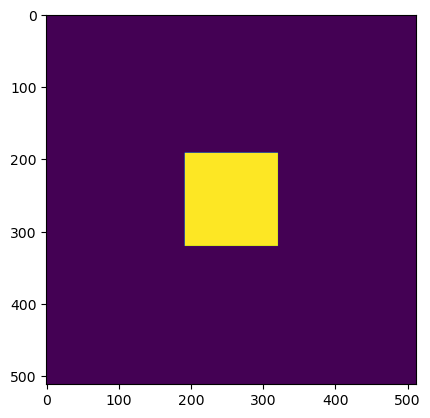

In [68]:
plt.imshow(U_box[0,...].cpu().cpu().numpy())

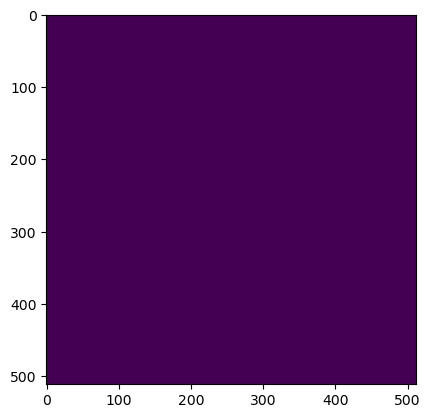

In [69]:
plt.imshow(((torch.abs(0.0 + U_prop)**2)).cpu().numpy()[0,...])

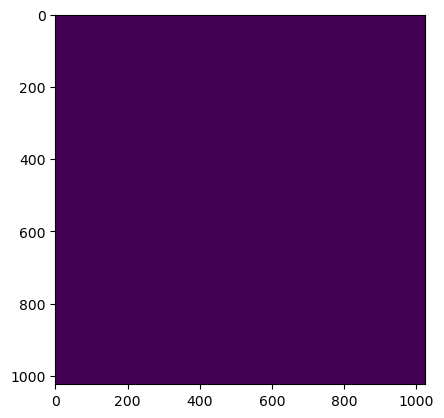

In [70]:
plt.imshow(constraint1.cpu().numpy()[0,...])